In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Auto_Encoder(nn.Module):
    def __init__(self,nb_channels,nb_encoded_features,img_size = (64,64,64)):
        nn.Module.__init__(self)
        self.nb_channels = nb_channels
        self.nb_encoded_features = nb_encoded_features
        self.img_size = img_size
        self.pool = nn.MaxPool3d(kernel_size = 4,return_indices = True)
        self.unpool = nn.MaxUnpool3d(kernel_size = 4)
        self.conv1 = nn.Conv3d(in_channels = nb_channels, out_channels = 8 , kernel_size = 3 , padding = 1)
        self.conv2 = nn.Conv3d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.encode_linear = nn.Linear(in_features = 1024, out_features = nb_encoded_features)
        self.decode_linear = nn.Linear(in_features = nb_encoded_features, out_features = 1024)
        self.deconv1 = nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv2 = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, padding = 1)
        self.deconv3 = nn.Conv3d(in_channels = 8, out_channels = nb_channels, kernel_size = 3, padding = 1)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x,indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x,indices2 = self.pool(x)
        x = F.relu(self.conv3(x))
        x,indices3 = self.pool(x)
        x = x.view(x.size()[0],-1) #Flatten
        encoded = self.encode_linear(x)
        x = self.decode_linear(encoded)
        x = x.view(x.size()[0],32,2,2,2)
        x = self.unpool(x,indices3)
        x = F.relu(self.deconv1(x))
        x = self.unpool(x,indices2)
        x = F.relu(self.deconv2(x))
        x = self.unpool(x,indices1)
        x = self.deconv3(x)
        decoded = x
        return x

In [12]:
def train_AE(AE,epochs = 501, batch_size = 4):
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(AE.parameters())
    start_time = datetime.datetime.now()
    losses = []
    torch.set_num_threads(8)
    for epoch in range(epochs):
        #load data
        N_train = 0.5 * len(os.listdir('Euler_Displacement'))
        inputs = np.zeros((batch_size,) + (AE.nb_channels,) + AE.img_size)
        for i in range(batch_size):
            idx = np.random.randint(0,N_train)
            img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
            #img = img.reshape((AE.nb_channels,) + AE.img_size)
            x = np.random.randint(0,224)
            patch = img[x:x+32,x:x+32,x:x+32]
            patch = patch.reshape((AE.nb_channels,) + AE.img_size)
            inputs[i] = patch
        
        inputs = torch.Tensor(inputs)
        #Gradient set to zero
        optimizer.zero_grad()
        
        # forward + backward 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #print(device)
        AE = AE.to(device)
        inputs = inputs.to(device)
        outputs = AE(inputs)
        loss = criterion(outputs, inputs)
        loss.backward() 
        
        #update parameters
        optimizer.step()
        
        losses.append(loss.item())
        if(epoch%10 ==0):
            print(loss.item())
            print(datetime.datetime.now() - start_time)
    
    np.save('history.npy',np.array(losses))
    return AE

In [4]:
AE = Auto_Encoder(nb_channels = 1,nb_encoded_features = 10)

In [13]:
AE = train_AE(AE)

82.94468688964844
0:00:00.360642
3.396165370941162
0:00:03.642764
29.695619583129883
0:00:07.081399
55.3591194152832
0:00:10.449440
18.389705657958984
0:00:13.795617
14.15456771850586
0:00:17.271412
18.106372833251953
0:00:20.476029
8.77189826965332
0:00:24.034873
1.2960683107376099
0:00:27.513466
4.211458206176758
0:00:30.857540
6.271265983581543
0:00:34.312086
9.156800270080566
0:00:37.860073
3.1489346027374268
0:00:41.153133
3.2595536708831787
0:00:44.510397
8.695523262023926
0:00:47.895305
11.04946517944336
0:00:51.319337
4.778578758239746
0:00:54.773883
0.7492628693580627
0:00:58.220561
44.08896255493164
0:01:01.535598
4.371532917022705
0:01:05.007359
2.4063355922698975
0:01:08.303401
4.807756423950195
0:01:11.728591
3.9324560165405273
0:01:15.259478
4.4159135818481445
0:01:18.619999
1.6675353050231934
0:01:21.937008
2.364781379699707
0:01:25.290836
1.5524420738220215
0:01:28.633771
0.5185885429382324
0:01:32.001162
1.520329236984253
0:01:35.258598
0.929302453994751
0:01:38.699516

In [14]:
history = np.load('history.npy')

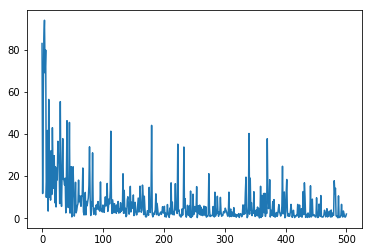

In [15]:
plt.plot(history)

In [20]:
testset = []
for idx in range(110,190):
    img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
    x = np.random.randint(0,224)
    patch = img[x:x+32,x:x+32,x:x+32]
    testset.append(patch)

In [21]:
testinput = np.array(testset)
testinput = testinput.reshape((testinput.shape[0],1,32,32,32))
testinput = torch.Tensor(testinput)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testinput = testinput.to(device)
testoutput = AE(testinput)
criterion = nn.MSELoss()
loss = criterion(testoutput, testinput)
print(loss)

tensor(5.8342, device='cuda:0', grad_fn=<MseLossBackward>)
